In [56]:
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [3]:
DATA_PATH = Path.cwd().parent.joinpath('data', 'raw')

In [49]:
market_values = pd.read_table(DATA_PATH.joinpath('prices_shares_outstanding_daily.txt'), dtype={'cusip': str, 'tpci': str}, parse_dates=['datadate'])
market_values['mkvaltq'] = market_values.prccd * market_values.cshoc

In [50]:
market_values.head()

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,iid,datadate,...,prchd,prcld,prcod,exchg,secstat,tpci,cik,fic,ccmbegdt,mkvaltq
0,1213,P,1,LU,51721,20031,19710105,20030815,1,2000-01-03,...,22.5000,21.1250,NaN,11,I,0,3000.0,USA,19990201,1.033642e+09
1,1213,P,1,LU,51721,20031,19710105,20030815,1,2000-01-04,...,22.1250,21.5625,NaN,11,I,0,3000.0,USA,19990201,1.048843e+09
2,1213,P,1,LU,51721,20031,19710105,20030815,1,2000-01-05,...,21.8125,21.2500,NaN,11,I,0,3000.0,USA,19990201,1.045803e+09
3,1213,P,1,LU,51721,20031,19710105,20030815,1,2000-01-06,...,24.0000,21.5000,NaN,11,I,0,3000.0,USA,19990201,1.158288e+09
4,1213,P,1,LU,51721,20031,19710105,20030815,1,2000-01-07,...,23.6875,22.6250,NaN,11,I,0,3000.0,USA,19990201,1.133967e+09


In [27]:
market_values.columns

Index(['GVKEY', 'LINKPRIM', 'LIID', 'LINKTYPE', 'LPERMNO', 'LPERMCO', 'LINKDT',
       'LINKENDDT', 'iid', 'datadate', 'tic', 'cusip', 'conm', 'cshoc',
       'prccd', 'prchd', 'prcld', 'prcod', 'exchg', 'secstat', 'tpci', 'cik',
       'fic', 'ccmbegdt', 'mkvaltq'],
      dtype='object')

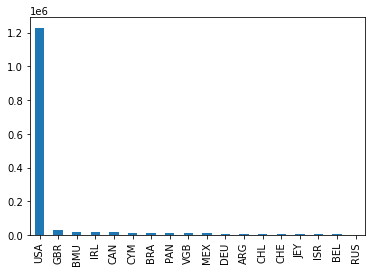

In [12]:
market_values.fic.value_counts().plot(kind='bar')

In [16]:
def get_bad_data(market_values):
    bad_data = list()
    for ticker in market_values.tic.unique():
        subset = market_values[market_values.tic==ticker]
        current = 'na' if np.isnan(subset.mkvaltq.iloc[0]) else 'val'
        for v in subset.mkvaltq[1:]:
            if not np.isnan(v):
                current = 'val'
            elif current == 'val' and np.isnan(v):
                bad_data.append((ticker, subset.conm.iloc[0]))
                continue
    return Counter(bad_data)

In [33]:
bad_data_1 = get_bad_data(market_values)
bad_data_1

Counter({('BDK', 'BLACK & DECKER CORP'): 1,
         ('KO', 'COCA-COLA CO'): 1,
         ('CAG', 'CONAGRA BRANDS INC'): 1,
         ('JCI', 'JOHNSON CONTROLS INTL PLC'): 1,
         ('NKE', 'NIKE INC  -CL B'): 1,
         ('MO', 'ALTRIA GROUP INC'): 1,
         ('RYL', 'RYLAND GROUP INC'): 1,
         ('SEB', 'SEABOARD CORP'): 1,
         ('WNDXQ', 'WINN-DIXIE STORES INC'): 1,
         ('WN', "WYNN'S INTERNATIONAL INC"): 1,
         ('HOG', 'HARLEY-DAVIDSON INC'): 1,
         ('CCEP', 'COCA-COLA EUROPEAN PARTNERS'): 1,
         ('STKL', 'SUNOPTA INC'): 15,
         ('HAR', 'HARMAN INTERNATIONAL INDS'): 1,
         ('MOND', 'MONDAVI ROBERT CORP  -CL A'): 1,
         ('EL', 'LAUDER (ESTEE) COS INC -CL A'): 1,
         ('TUP', 'TUPPERWARE BRANDS CORP'): 1,
         ('CALM', 'CAL-MAINE FOODS INC'): 1,
         ('TIVO', 'TIVO CORP'): 1,
         ('SVM', 'SILVERCORP METALS INC'): 1,
         ('DPHIQ', 'APTIV PLC'): 1,
         ('TWE', 'TD WATERHOUSE GROUP INC'): 1,
         ('SNMX', 'SENOMYX

In [34]:
for elem in bad_data_1.items():
    if elem[1] == 1:
        subset = market_values[market_values.tic == elem[0][0]]
        ind = subset[subset.mkvaltq.isna()].index[-1]
        if ind == subset.index[-1]:
            subset.loc[ind, 'mkvaltq'] = subset.loc[ind-1, 'mkvaltq']
        else:
            subset.loc[ind, 'mkvaltq'] = (subset.loc[ind-1, 'mkvaltq'] + subset.loc[ind+1, 'mkvaltq']) / 2
        market_values[market_values.tic == elem[0][0]] = subset

/home/cspa33/miniconda3/envs/ORIE5370/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [35]:
get_bad_data(market_values)

Counter({('STKL', 'SUNOPTA INC'): 15})

In [38]:
last_mkt_cap = list()
for tick in market_values.tic.unique():
    subset = market_values[market_values.tic == tick]
    val = subset.mkvaltq.values[-1]
    if not np.isnan(val):
        if val < 0.2*100_000_000_000:
#             print(f'{tick}: {val*1_000_000:,}')
            last_mkt_cap.append(subset.mkvaltq.values[-1]*1_000_000)

(array([92., 61., 31., 25., 13., 20., 15.,  9.,  9.,  9.,  4.,  6.,  4.,
         3.,  3.,  2.,  4.,  2.,  1.,  2.]),
 array([1.01646000e+12, 9.99339637e+14, 1.99766281e+15, 2.99598599e+15,
        3.99430917e+15, 4.99263234e+15, 5.99095552e+15, 6.98927870e+15,
        7.98760188e+15, 8.98592505e+15, 9.98424823e+15, 1.09825714e+16,
        1.19808946e+16, 1.29792178e+16, 1.39775409e+16, 1.49758641e+16,
        1.59741873e+16, 1.69725105e+16, 1.79708336e+16, 1.89691568e+16,
        1.99674800e+16]),
 <a list of 20 Patch objects>)

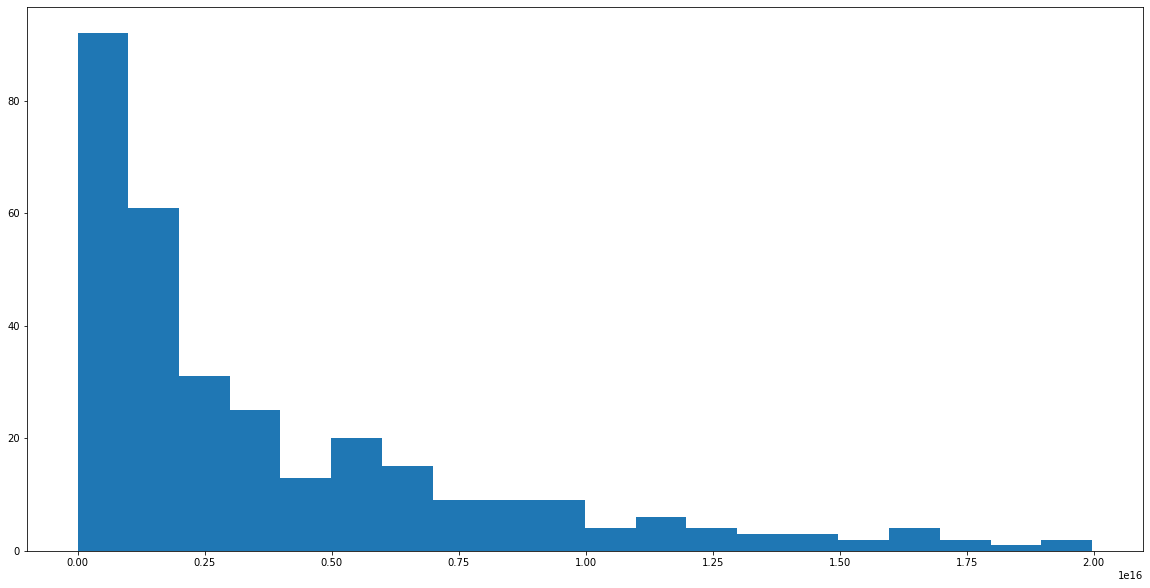

In [39]:
plt.figure(figsize=(20,10))
plt.hist(last_mkt_cap, bins=20)

In [53]:
monthly_vals = market_values[market_values.datadate.dt.is_month_end]

In [80]:
monthly_vals[monthly_vals.mkvaltq.isna()]

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,iid,datadate,...,prchd,prcld,prcod,exchg,secstat,tpci,cik,fic,ccmbegdt,mkvaltq
963391,31227,P,1,LC,88379,37746,20000616,20010524,1,2000-06-30,...,14.0000,13.7500,NaN,14,I,0,1096376.0,USA,19990701,NaN
963411,31227,P,1,LC,88379,37746,20000616,20010524,1,2000-07-31,...,13.5000,12.8750,NaN,14,I,0,1096376.0,USA,19990801,NaN
963434,31227,P,1,LC,88379,37746,20000616,20010524,1,2000-08-31,...,11.8750,11.7500,NaN,14,I,0,1096376.0,USA,19990901,NaN
963476,31227,P,1,LC,88379,37746,20000616,20010524,1,2000-10-31,...,1.2500,1.0938,NaN,14,I,0,1096376.0,USA,19991101,NaN
963497,31227,P,1,LC,88379,37746,20000616,20010524,1,2000-11-30,...,1.1875,1.1250,NaN,14,I,0,1096376.0,USA,19991201,NaN
963538,31227,P,1,LC,88379,37746,20000616,20010524,1,2001-01-31,...,0.8750,0.8125,NaN,14,I,0,1096376.0,USA,20000201,NaN
963557,31227,P,1,LC,88379,37746,20000616,20010524,1,2001-02-28,...,0.9063,0.9063,NaN,14,I,0,1096376.0,USA,20000301,NaN
963599,31227,P,1,LC,88379,37746,20000616,20010524,1,2001-04-30,...,0.6800,0.6000,NaN,14,I,0,1096376.0,USA,20000501,NaN
997676,37101,P,90,LC,19819,57338,20200930,E,90,2020-09-30,...,16.7600,14.0000,14.5,14,A,F,1807192.0,CYM,20191001,NaN
1223917,142812,P,1,LC,90238,45309,20040622,20181130,1,2004-06-30,...,6.2500,6.0100,NaN,14,I,0,1123979.0,USA,20030701,NaN


In [65]:
returns = {'small': [], 'big': []}
tickers = {'small':[], 'big': []}
caps = {'small':[], 'big':[]}
for tick in tqdm_notebook(monthly_vals.tic.unique()):
    subset = monthly_vals[monthly_vals.tic == tick]
    subset['return'] = subset.prccd.pct_change()
    if subset.mkvaltq.values[-1] > 20_000_000_000:
        returns['big'].append(subset['return'].mean())
        tickers['big'].append(tick)
        caps['big'].append(subset.mkvaltq.values[-1])
    else:
        returns['small'].append(subset['return'].mean())
        tickers['small'].append(tick)
        caps['small'].append(subset.mkvaltq.values[-1])

<ipython-input-65-4461c30e9674>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tick in tqdm_notebook(monthly_vals.tic.unique()):


  0%|          | 0/385 [00:00<?, ?it/s]

<ipython-input-65-4461c30e9674>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['return'] = subset.prccd.pct_change()


In [66]:
npsmall = np.array(returns['small'])
npbig = np.array(returns['big'])

In [67]:
np.where(npsmall > 5)

(array([], dtype=int64),)

In [16]:
npsmall = np.delete(npsmall, 297)
del tickers['small'][297]
del returns['small'][297]
del caps['small'][297]

In [17]:
for t in np.where(npsmall > 5)[0]:
    print(tickers['small'][t])
    print(npsmall[t])

/Users/siddharthkantamneni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [70]:
np.nanmean(npsmall) - np.nanmean(npbig)

0.005834597015238641

In [71]:
ticks = []
capsize = []
rets = []
for i in range(len(tickers['small'])):
    ticks.append(tickers['small'][i])
    capsize.append(caps['small'][i])
    rets.append(returns['small'][i])

for i in range(len(tickers['big'])):
    ticks.append(tickers['big'][i])
    capsize.append(caps['big'][i])
    rets.append(returns['big'][i])

In [102]:
q = []
for i in range(0, 100, 20):
    mask = np.logical_and(capsize > np.percentile(capsize,i), capsize<np.percentile(capsize,i+10))
    rr = rets[mask]
    q.append(np.mean(rr))

<BarContainer object of 5 artists>

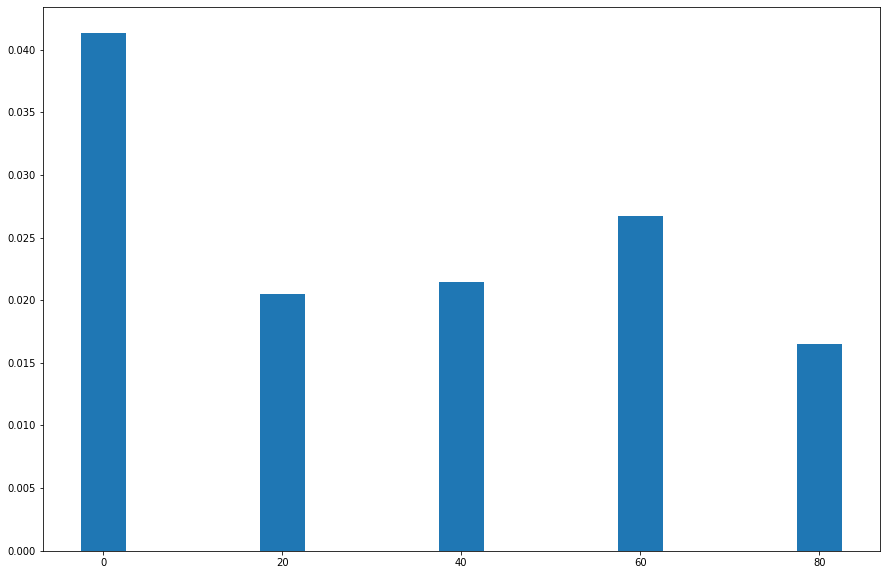

In [103]:
plt.figure(figsize=(15, 10))
plt.bar(x = range(0,100,20), height=q, width=5)